In [1]:
# https://github.com/aaaquants/option-volatility-surface/blob/master/VolSurfacePlot.ipynb

import yfinance as yf
from dateutil.parser import parse
from datetime import datetime
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
from matplotlib.colors import LogNorm
#%matplotlib notebook
#from implied_vol import BlackScholes
from functools import partial
from scipy import optimize
import numpy as np
from scipy.interpolate import griddata
import pandas as pd
pd.options.mode.chained_assignment = None  # default='warn'
import scipy.stats as st


In [2]:
msft = yf.Ticker("MSFT")
msft.options
print("expiries. ", msft.options)
#print(opt.calls['volume']) # calls, count, index, puts
#print(expiry)
lookback_days = 2
history = msft.history(period=str(lookback_days)+'d')['Close'] # make sure we have enough data

expiries.  ('2021-07-16', '2021-07-23', '2021-07-30', '2021-08-06', '2021-08-13', '2021-08-20', '2021-08-27', '2021-09-17', '2021-10-15', '2021-11-19', '2022-01-21', '2022-03-18', '2022-06-17', '2022-09-16', '2023-01-20', '2023-03-17', '2023-06-16')


In [3]:
def CND(X):
 
    (a1,a2,a3,a4,a5) = (0.31938153, -0.356563782, 1.781477937, -1.821255978, 1.330274429)
    
    L = abs(X)
    K = 1.0 / (1.0 + 0.2316419 * L)
    w = 1.0 - 1.0 / np.sqrt(2*np.pi)*np.exp(-L*L/2.) * (a1*K + a2*K*K + a3*pow(K,3) + a4*pow(K,4) + a5*pow(K,5))
    
    if X<0:
        w = 1.0-w
 
    return w

def BlackScholes(v,CallPutFlag = 'c',S = 100.,X = 100.,T = 1.,r = 0.01):
 
    d1 = (np.log(S/X)+(r+v*v/2.)*T)/(v*np.sqrt(T))
    d2 = d1-v*np.sqrt(T)
    
    if CallPutFlag=='c':
        return S*CND(d1)-X*np.exp(-r*T)*CND(d2)
 
    else:
        return X*np.exp(-r*T)*CND(-d2)-S*CND(-d1)
    
def calc_impl_vol(price = 5., right = 'c', underlying = 100., strike = 100., time = 1., rf = 0.0, inc = 0.001):
    
    def f(x):
        out = (BlackScholes(x,CallPutFlag=right,S=underlying,X=strike,T=time,r=rf)-price)**2 
        if x < 0.0:
            out += 1000.0 * (x)**2
        return out
  
    return optimize.minimize(f,x0=0.5, tol=1e-8, method='Nelder-Mead')

def plot3D(X,Y,Z,labels=None,title=None):
    fig = plt.figure()
    ax = Axes3D(fig, azim = -29, elev = 40)
 
    ax.plot(X,Y,Z,'o')
      
    if labels is not None:
        if labels[0] is not None:
            ax.set_xlabel(labels[0])
        if labels[1] is not None:
            ax.set_ylabel(labels[1])
        if labels[2] is not None:
            ax.set_zlabel(labels[2])
    if title is not None:
        ax.set_title(title)
    plt.show()
    
def make_surf(X,Y,Z):
    XX,YY = np.meshgrid(np.linspace(min(X),max(X),350),np.linspace(0.4,1.4,350))
#    XX,YY = np.meshgrid(np.linspace(min(X),max(X),350),np.linspace(min(Y),max(Y),350))
    ZZ = griddata(np.array([X,Y]).T,np.array(Z),(XX,YY))
    return XX,YY,ZZ

def mesh_plot2(X,Y,Z,labels=None,title=None):
    fig = plt.figure()
    ax = Axes3D(fig, azim = -29, elev = 40)
    XX,YY,ZZ = make_surf(X,Y,Z)

    ax.plot_surface(XX,YY,ZZ)
    ax.contour(XX,YY,ZZ)
    if labels is not None:
        if 'x' in labels:
            ax.set_xlabel(labels['x'])
        if 'y' in labels:
            ax.set_ylabel(labels['y'])
        if 'z' in labels:
            ax.set_zlabel(labels['z'])
    if title is not None:
        ax.set_title(title)
    plt.show()
    

def ImpliedVolatility(CP,S_0,K,sigma,tau,r,V_market,log=False):
    error    = 1e10; # initial error
    #Handy lambda expressions
    optPrice = lambda sigma: BS_Call_Option_Price(CP,S_0,K,sigma,tau,r)
    vega= lambda sigma: dV_dsigma(S_0,K,sigma,tau,r)
    
    # While the difference between the model and the arket price is large
    # follow the iteration
    n = 1.0 
    while error>10e-10:
        g         = optPrice(sigma) - V_market
        g_prim    = vega(sigma)
        sigma_new = sigma - g / g_prim
    
        #error=abs(sigma_new-sigma)
        error=abs(g)
        sigma=sigma_new;
        if log:
            print('iteration {0} with error = {1}'.format(n,error))
        
        n= n+1
    return sigma

# Vega, dV/dsigma
def dV_dsigma(S_0,K,sigma,tau,r):
    #parameters and value of Vega
    d2   = (np.log(S_0 / float(K)) + (r - 0.5 * np.power(sigma,2.0)) * tau) / float(sigma * np.sqrt(tau))
    value = K * np.exp(-r * tau) * st.norm.pdf(d2) * np.sqrt(tau)
    return value

def BS_Call_Option_Price(CP,S_0,K,sigma,tau,r):
    #Black-Scholes Call option price
    d1    = (np.log(S_0 / float(K)) + (r + 0.5 * np.power(sigma,2.0)) * tau) / float(sigma * np.sqrt(tau))
    d2    = d1 - sigma * np.sqrt(tau)
    if str(CP).lower()=="c" or str(CP).lower()=="1":
        value = st.norm.cdf(d1) * S_0 - st.norm.cdf(d2) * K * np.exp(-r * tau)
    elif str(CP).lower()=="p" or str(CP).lower()=="-1":
        value = st.norm.cdf(-d2) * K * np.exp(-r * tau) - st.norm.cdf(-d1)*S_0
    return value

In [41]:
data = []
today = datetime.now()
rf = 0.0
rel_tol = 1e-8
opt_type = 'c'
# T, K/S, price/S
# call
for mat in msft.options:
    opt = msft.option_chain(mat)
    options = opt.calls
    options = options[options['inTheMoney']==False] # only OTM
    options['premium'] = 0.5*(options['bid']+options['ask'])
#    avg_volume = calls['volume'].mean()
    qtile = options['volume'].quantile(0.3)
    for (ind, contract) in options.iterrows():
        if contract['volume'] <= qtile:
            continue
        lastTradeDate = pd.to_datetime(contract['lastTradeDate'].date())
        try:
            underlying = history.loc[lastTradeDate]
        except:
            continue
        strike = contract['strike']
        price = contract['premium']
        tenor = (pd.to_datetime(mat)-today).ceil('D').days
        tenor /= 365.0 # annualization
#         tenor /= 252.0 # annualization
        res = calc_impl_vol(price = price, right = opt_type, underlying = underlying, strike = strike, time = tenor, rf = rf)
        ivol = res.x[0]
#         ivol = ImpliedVolatility('C',underlying,strike,sigmaInit,tau,rf,price)
#         if ivol >= 0.6:
#             continue
        price_iv = BlackScholes(ivol,CallPutFlag=opt_type,S=underlying,X=strike,T=tenor,r=rf)
        rel_error = (price - price_iv)/price
        if abs(rel_error) >= rel_tol:
            continue
        else:
            w = tenor*np.power(ivol,2)
            data.append([tenor, opt_type, strike/underlying, np.log(strike/underlying), price/underlying, ivol, w, rel_error]) # normalized strike and option price

# put
opt_type = 'p'
for mat in msft.options:
    opt = msft.option_chain(mat)
    options = opt.puts
    options = options[options['inTheMoney']==False] # only OTM
    options['premium'] = 0.5*(options['bid']+options['ask'])
#    avg_volume = calls['volume'].mean()
    qtile = options['volume'].quantile(0.3)
    for (ind, contract) in options.iterrows():
        if contract['volume'] <= qtile:
            continue
        lastTradeDate = pd.to_datetime(contract['lastTradeDate'].date())
        try:
            underlying = history.loc[lastTradeDate]
        except:
            continue
        strike = contract['strike']
        price = contract['premium']
        tenor = (pd.to_datetime(mat)-today).ceil('D').days
        tenor /= 365.0 # annualization
#         tenor /= 252.0 # annualization
        res = calc_impl_vol(price = price, right = opt_type, underlying = underlying, strike = strike, time = tenor, rf = rf)
        ivol = res.x[0]
#         ivol = ImpliedVolatility('C',underlying,strike,sigmaInit,tau,rf,price)
#         if ivol >= 0.6:
#             continue
        price_iv = BlackScholes(ivol,CallPutFlag=opt_type,S=underlying,X=strike,T=tenor,r=rf)
        rel_error = (price - price_iv)/price
        if abs(rel_error) >= rel_tol:
            continue
        else:
            w = tenor*np.power(ivol,2)
            data.append([tenor, opt_type, strike/underlying, np.log(strike/underlying), price/underlying, ivol, w, rel_error]) # normalized strike and option price

            
            
df = pd.DataFrame(data,columns=['tenor','type','k','log_k','price','ivol','w','rel_error'])
df = df.sort_values(by=['tenor','log_k']).reset_index(drop=True)
df.dropna(inplace=True)
df.to_csv('ivol_surface.csv',index=False)
tenors = df['tenor'].unique()

C:\Users\golde\Anaconda3\lib\site-packages\ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
C:\Users\golde\Anaconda3\lib\site-packages\ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in double_scalars
  app.launch_new_instance()
C:\Users\golde\Anaconda3\lib\site-packages\ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
C:\Users\golde\Anaconda3\lib\site-packages\ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in double_scalars
  app.launch_new_instance()


In [42]:
df['w1'] = np.zeros(df.shape[0]) # first order derivative
df['w2'] = np.zeros(df.shape[0]) # 2nd order derivative
for ind,tenor in enumerate(tenors):
    tmp = df[df['tenor']==tenor]
    d_logk = tmp['log_k'].diff()
    d_tot_var = tmp['w'].diff()
    d_logk2 = d_logk.shift(-1) - d_logk
    d_tot_var2 = d_tot_var.shift(-1) - d_tot_var
    df['w1'].loc[tmp.index] = d_tot_var / d_logk
    df['w2'].loc[tmp.index] = d_tot_var2 / d_logk2
    
df.dropna(inplace=True)
tenors = df['tenor'].unique()

In [43]:
w = df['w']
w1 = df['w1']
w2 = df['w2']
k = df['log_k']
df['g'] = (1-k*w1/(2*w)).pow(2) - w1.pow(2)/4*(1/w+1/4) + w2/2

Text(0, 0.5, 'Ivol (%)')

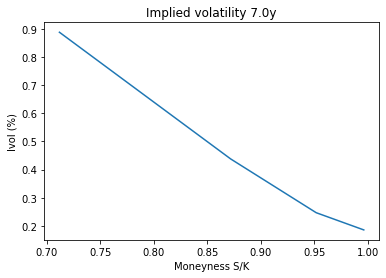

In [49]:
tenor = tenors[0]
x = df[df['tenor']==tenor]['k']
y = df[df['tenor']==tenor]['ivol']
plt.plot(x.values,y.values)
plt.title('Implied volatility '+str(tenor*365)+'y')
plt.xlabel('Moneyness S/K')
plt.ylabel('Ivol (%)')

In [9]:
df_raw_svi = {'tenors':tenors, 'a':np.zeros(len(tenors)),'b':np.zeros(len(tenors)),'rho':np.zeros(len(tenors)),'m':np.zeros(len(tenors)),'sig':np.zeros(len(tenors))}
df_raw_svi = pd.DataFrame(df_raw_svi)
# 1 > b >= 0, |rho| < 1, sig > 0, 2*min_k < sig < 2*max_k

In [10]:
# Initial guess
for ind,tenor in enumerate(tenors):
    df_raw_svi['a'].iloc[ind] = 0.5 * df[df['tenor']==tenor]['w'].min()
    df_raw_svi['b'].iloc[ind] = 0.1
    df_raw_svi['m'].iloc[ind] = 0.1
    df_raw_svi['sig'].iloc[ind] = 0.1
    df_raw_svi['rho'].iloc[ind] = -0.5

In [131]:
def get_w_svi(params,df):
    a = params[0]
    b = params[1]
    rho = params[2]
    m = params[3]
    sig = params[4]
    if 'w_svi' not in df.columns:
        df['w_svi'] = 0 # make a column
    k = df['log_k']
    df['w_svi'] = a + b*(rho*(k-m) + ((k-m).pow(2) + sig**2).pow(0.5))

def get_g(params,df):
    w = df['w_svi']
    d_logk = df['log_k'].diff()
    d_tot_var = w.diff()
    d_logk2 = d_logk.shift(-1) - d_logk
    d_tot_var2 = d_tot_var.shift(-1) - d_tot_var
    w1 = d_tot_var / d_logk
    w2 = d_tot_var2 / d_logk2
    g = (1-k*w1/(2*w)).pow(2) - w1.pow(2)/4*(1/w+1/4) + w2/2
    g = g.dropna()
    return g
    
def obj_fun(x0, df):
    get_w_svi(x0,df)
    res = (df['w'] - df['w_svi']).pow(2).sum()
    g = get_g(x0,df)
    res += g[g<0.0].pow(2).sum()
    return res

In [132]:
tmp = df[df['tenor']==tenors[0]] # first tenor
of = lambda x: obj_fun(x,tmp) 
x0 = df_raw_svi.loc[0].values[1:]
print('Initial function ',of(x0))
res = optimize.minimize(of,x0=x0, tol=1e-8, method='Nelder-Mead')
print('Final function ',res['fun'])

Initial function  0.004954083329232666
Final function  2.6384558073181855e-06


<AxesSubplot:>

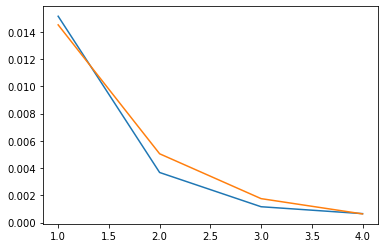

In [135]:
tmp['w'].plot()
get_w_svi(res['x'],tmp)
tmp['w_svi'].plot()

array([-2.09755062e-04,  2.04000275e-02, -1.40235742e+00, -4.54623023e-02,
        9.09942381e-02])

In [130]:
tenors[0]

0.019178082191780823

In [98]:
obj_fun(x0,tmp)

0.004954083329232666

In [82]:
df['w_svi'] = 0

In [85]:
tmp

tenor type         k     log_k     price      ivol         w  \
1  0.019178    p  0.711668 -0.340144  0.000089  0.888648  0.015145   
2  0.019178    p  0.871793 -0.137203  0.000231  0.437930  0.003678   
3  0.019178    p  0.951856 -0.049342  0.001103  0.246453  0.001165   
4  0.019178    p  0.996335 -0.003672  0.008487  0.185235  0.000658   

      rel_error        w1        w2         g     w_svi  
1  2.202495e-09  0.082066 -0.076254  3.542716  0.067726  
2  1.922094e-09 -0.056503 -0.077804 -0.253204  0.038185  
3 -9.186122e-09 -0.028604 -0.047554 -0.044036  0.026023  
4  2.642895e-09 -0.011097 -0.017486  0.883497  0.020170

In [88]:
df.head(100)

tenor type         k     log_k     price      ivol         w  \
1    0.019178    p  0.711668 -0.340144  0.000089  0.888648  0.015145   
2    0.019178    p  0.871793 -0.137203  0.000231  0.437930  0.003678   
3    0.019178    p  0.951856 -0.049342  0.001103  0.246453  0.001165   
4    0.019178    p  0.996335 -0.003672  0.008487  0.185235  0.000658   
7    0.038356    p  0.765043 -0.267823  0.000267  0.570240  0.012472   
..        ...  ...       ...       ...       ...       ...       ...   
118  0.920548    p  0.973417 -0.026943  0.085395  0.260474  0.062456   
119  0.920548    p  0.996335 -0.003672  0.093851  0.251015  0.058002   
120  0.920548    c  1.103085  0.098111  0.049283  0.228621  0.048115   
121  0.920548    c  1.156460  0.145364  0.032915  0.219871  0.044502   
122  0.920548    c  1.174252  0.160631  0.030780  0.224632  0.046450   

        rel_error        w1        w2         g  w_svi  
1    2.202495e-09  0.082066 -0.076254  3.542716      0  
2    1.922094e-09 -0.056503 -0.077804 -0.253204      0  
3   -9.186122e-09 -0.028604 -0.047554 -0.044036      0  
4    2.642895e-09 -0.011097 -0.017486  0.883497      0  
7    1.313551e-09 -0.069312  1.221851  0.579772      0  
..            ...       ...       ...       ...    ...  
118 -8.044481e-10 -0.012888  0.288786  1.138165      0  
119  3.157342e-09 -0.191398 -0.069205  0.793133      0  
120  5.363468e-09 -0.097143 -0.115076  1.100733      0  
121 -3.434387e-10 -0.076448 -0.173838  1.145185      0  
122 -1.367086e-09  0.127585 -0.023161  0.507254      0  

[100 rows x 12 columns]

In [13]:
obj_fun(df_raw_svi, df)

0.05307438328646813

In [16]:
for ind,row in df_raw_svi.iterrows():
    x0 = row.values[1:]
    print(row)
row

tenors    0.019178
a         0.000582
b         0.100000
rho      -0.500000
m         0.100000
sig       0.100000
Name: 0, dtype: float64
tenors    0.038356
a         0.001941
b         0.100000
rho      -0.500000
m         0.100000
sig       0.100000
Name: 1, dtype: float64
tenors    0.057534
a         0.001790
b         0.100000
rho      -0.500000
m         0.100000
sig       0.100000
Name: 2, dtype: float64
tenors    0.076712
a         0.002987
b         0.100000
rho      -0.500000
m         0.100000
sig       0.100000
Name: 3, dtype: float64
tenors    0.095890
a         0.002439
b         0.100000
rho      -0.500000
m         0.100000
sig       0.100000
Name: 4, dtype: float64
tenors    0.115068
a         0.003329
b         0.100000
rho      -0.500000
m         0.100000
sig       0.100000
Name: 5, dtype: float64
tenors    0.172603
a         0.004196
b         0.100000
rho      -0.500000
m         0.100000
sig       0.100000
Name: 6, dtype: float64
tenors    0.249315
a         0.006

tenors         a    b  rho    m  sig
0   0.019178  0.000582  0.1 -0.5  0.1  0.1
1   0.038356  0.001941  0.1 -0.5  0.1  0.1
2   0.057534  0.001790  0.1 -0.5  0.1  0.1
3   0.076712  0.002987  0.1 -0.5  0.1  0.1
4   0.095890  0.002439  0.1 -0.5  0.1  0.1
5   0.115068  0.003329  0.1 -0.5  0.1  0.1
6   0.172603  0.004196  0.1 -0.5  0.1  0.1
7   0.249315  0.006035  0.1 -0.5  0.1  0.1
8   0.345205  0.009659  0.1 -0.5  0.1  0.1
9   0.517808  0.015239  0.1 -0.5  0.1  0.1
10  0.671233  0.021252  0.1 -0.5  0.1  0.1
11  0.920548  0.030222  0.1 -0.5  0.1  0.1
12  1.169863  0.047579  0.1 -0.5  0.1  0.1
13  1.515068  0.053196  0.1 -0.5  0.1  0.1
14  1.917808  0.065837  0.1 -0.5  0.1  0.1

In [25]:
df_raw_svi

tenors         a    b  rho    m  sig
0   0.019178  0.000582  0.1 -0.5  0.1  0.1
1   0.038356  0.001941  0.1 -0.5  0.1  0.1
2   0.057534  0.001790  0.1 -0.5  0.1  0.1
3   0.076712  0.002987  0.1 -0.5  0.1  0.1
4   0.095890  0.002439  0.1 -0.5  0.1  0.1
5   0.115068  0.003329  0.1 -0.5  0.1  0.1
6   0.172603  0.004196  0.1 -0.5  0.1  0.1
7   0.249315  0.006035  0.1 -0.5  0.1  0.1
8   0.345205  0.009659  0.1 -0.5  0.1  0.1
9   0.517808  0.015239  0.1 -0.5  0.1  0.1
10  0.671233  0.021252  0.1 -0.5  0.1  0.1
11  0.920548  0.030222  0.1 -0.5  0.1  0.1
12  1.169863  0.047579  0.1 -0.5  0.1  0.1
13  1.515068  0.053196  0.1 -0.5  0.1  0.1
14  1.917808  0.065837  0.1 -0.5  0.1  0.1